John Klein: 10044346  
Kristian Rehn: 10043938

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn as nn
from torch.optim import Adam

from torchvision.datasets import CIFAR10
from tqdm import tqdm

# Task 1

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '/data'
train_dataset = CIFAR10(path, transform=transform, download=True)
test_dataset  = CIFAR10(path, transform=transform, download=True)

# create train and testt dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device

device(type='cpu')

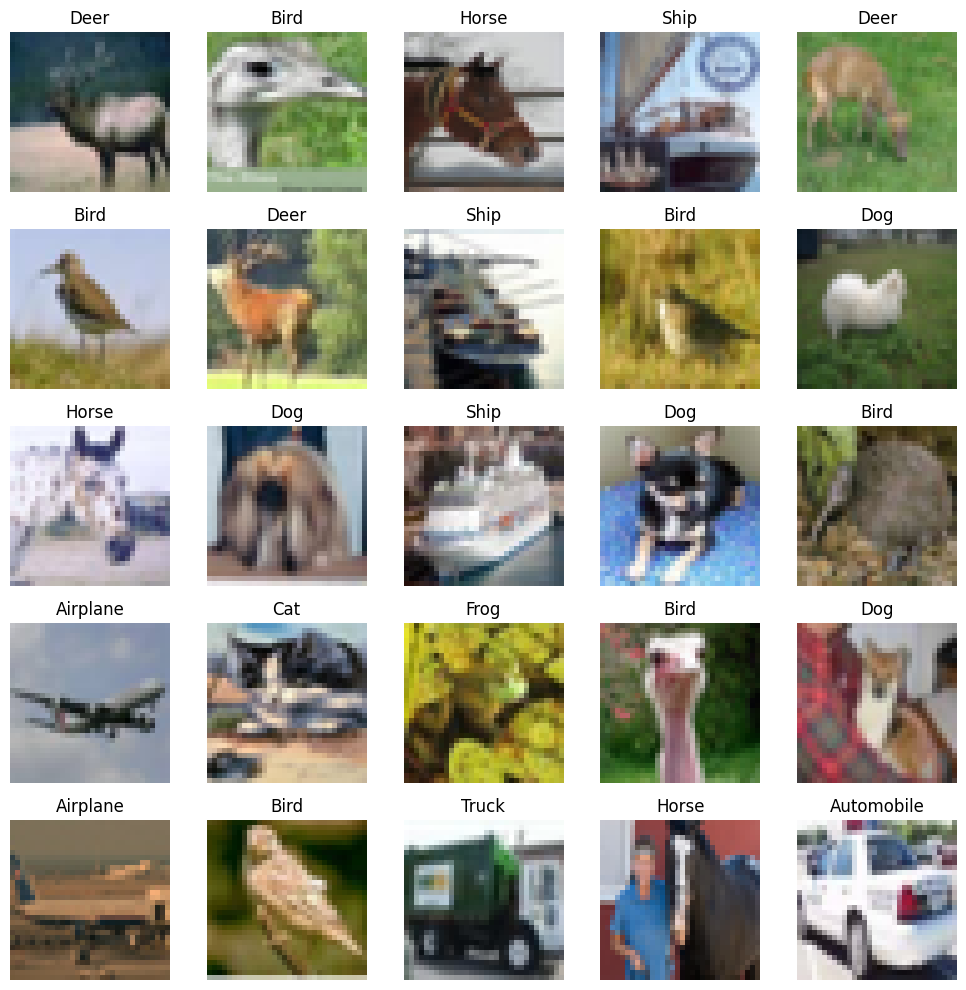

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images in a grid
def display_images(images, labels, classes):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(25):
        #change dimensions to correct color
        img = np.transpose(images[i].numpy(), (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))

classes = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

display_images(images, labels, classes)


# Task 2

## Explanation:

I used the design example from the exercise and tried some other adjustments, but these had little effect, so I only adjusted the numbers a little. I set the number of latent dimensions to 30. This is the point where the quality is no longer significantly increased and the number is not yet too high for the autoencoder to make sense

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lin1 = nn.Linear(32*8*8, 512)
        self.lin2 = nn.Linear(512, 30)

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.reshape(inp.shape[0], -1)
        out = self.lin1(out)
        return self.lin2(self.relu(out))

In [ ]:
encoder = Encoder()

In [ ]:
for X, label in train_loader:
    X = X.to(torch.float32)
    out = encoder(X)
    break

In [ ]:
out.shape

torch.Size([100, 30])

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(30, 256)
        self.lin2 = nn.Linear(256, 1024)
        self.lin3 = nn.Linear(1024, 3 * 32 * 32)
        self.relu = nn.ReLU()

    def forward(self, z):
        out = self.lin1(z)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.relu(out)
        out = self.lin3(out)
        out = out.view(z.shape[0], 3, 32, 32)
        return out

In [ ]:
decoder = Decoder()

In [ ]:
for X, label in train_loader:
    X = X.to(torch.float32)
    print(X.shape)
    out = encoder(X)
    X_hat = decoder(out)
    print(X_hat.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100, 3, 32, 32])


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, inp):
        out = self.encoder(inp)
        return self.decoder(out)

# Task 3:
The mean squared error calculates the error in each data point by squaring the deviation and then calculating the average per point. By squaring it, we hoped that the larger deviations would be reduced and the general structures would be better represented.

In [ ]:
auto_encoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = Adam(auto_encoder.parameters(), lr=0.001)

# Task 4

In [ ]:
def display_reconstructions(autoencoder, dataset, epoch, device):

    autoencoder.eval()

    classes = dataset.classes
    samples = {}
    for img, label in dataset:
        if label not in samples:
            samples[label] = img
        if len(samples) == len(classes):
            break

    sample_images = torch.stack([samples[i] for i in range(len(classes))])
    sample_images = sample_images.to(device)

    with torch.no_grad():
        reconstructed_images = autoencoder(sample_images)

    fig, axes = plt.subplots(2, len(classes), figsize=(15, 5))
    for i in range(len(classes)):
        # Original images
        axes[0, i].imshow(sample_images[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title(f"Original: {classes[i]}")
        axes[0, i].axis("off")

        # Generated images
        axes[1, i].imshow(reconstructed_images[i].cpu().permute(1, 2, 0).numpy())
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.suptitle(f"Epoch {epoch + 1}: Original vs. Reconstructed", fontsize=16)
    plt.tight_layout()
    plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


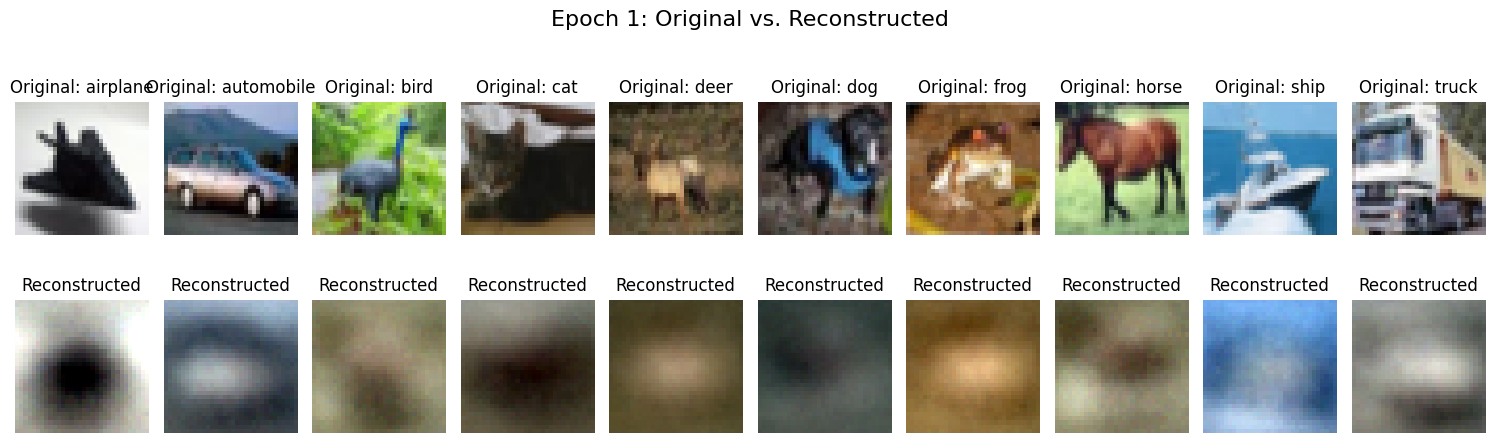

  3%|▎         | 1/30 [01:23<40:34, 83.95s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


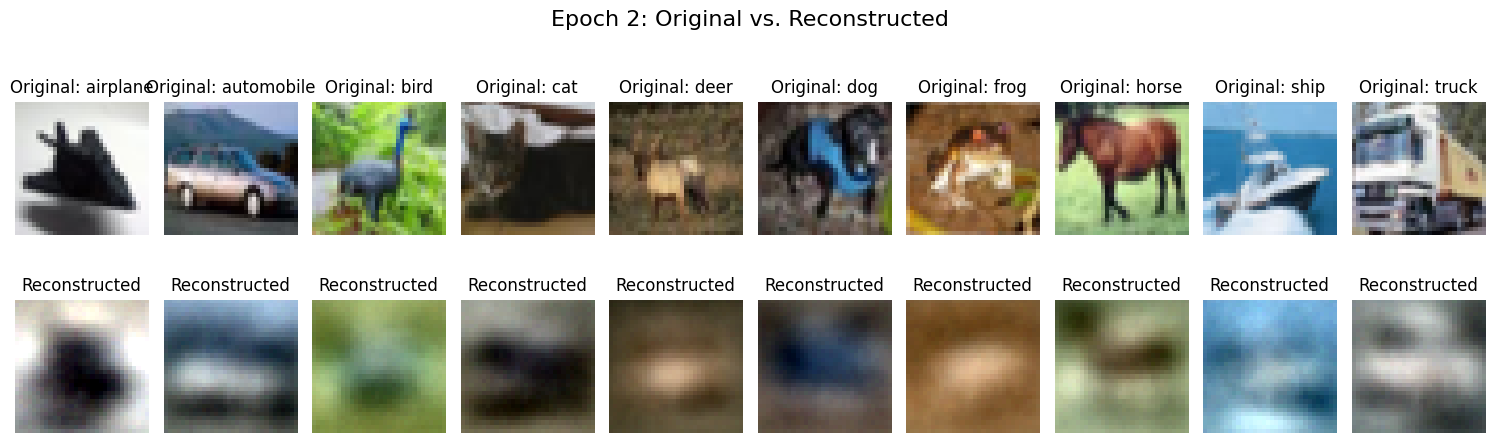

  7%|▋         | 2/30 [03:09<45:02, 96.52s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


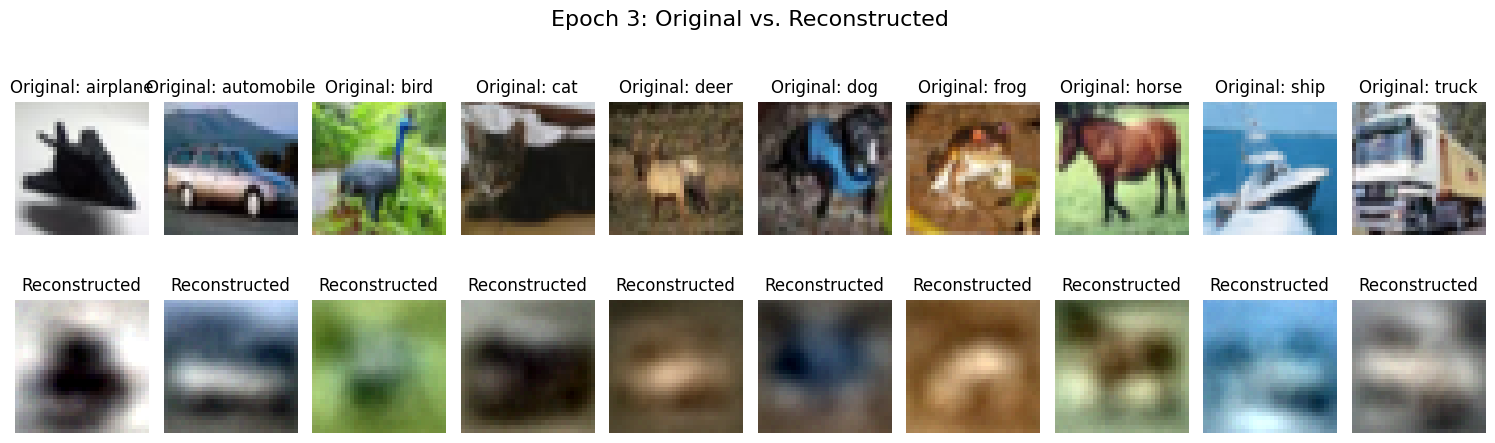

 10%|█         | 3/30 [05:03<47:08, 104.74s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


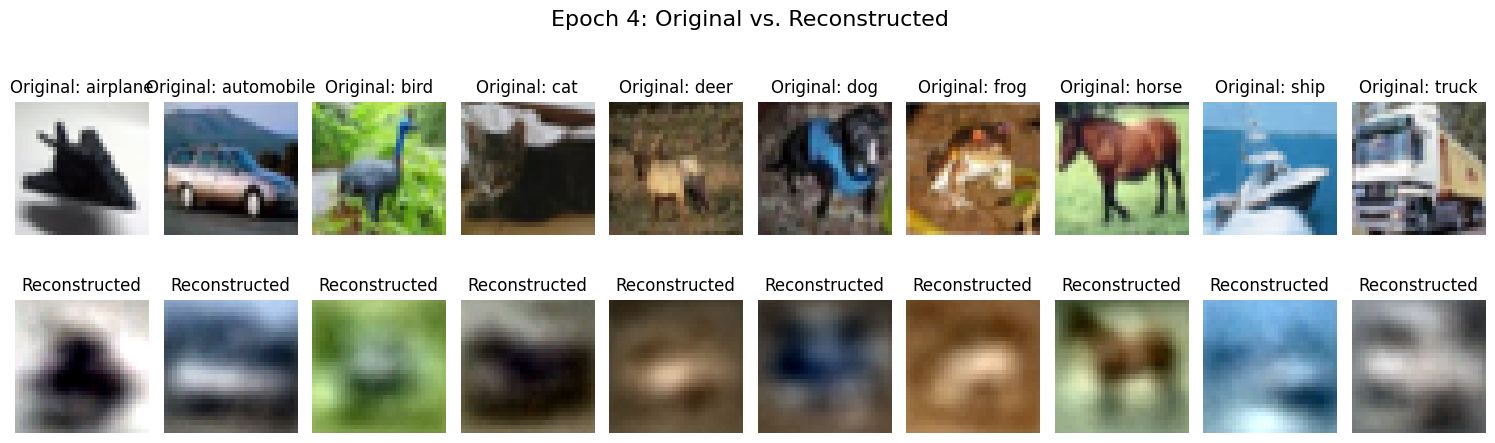

 13%|█▎        | 4/30 [06:55<46:31, 107.36s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


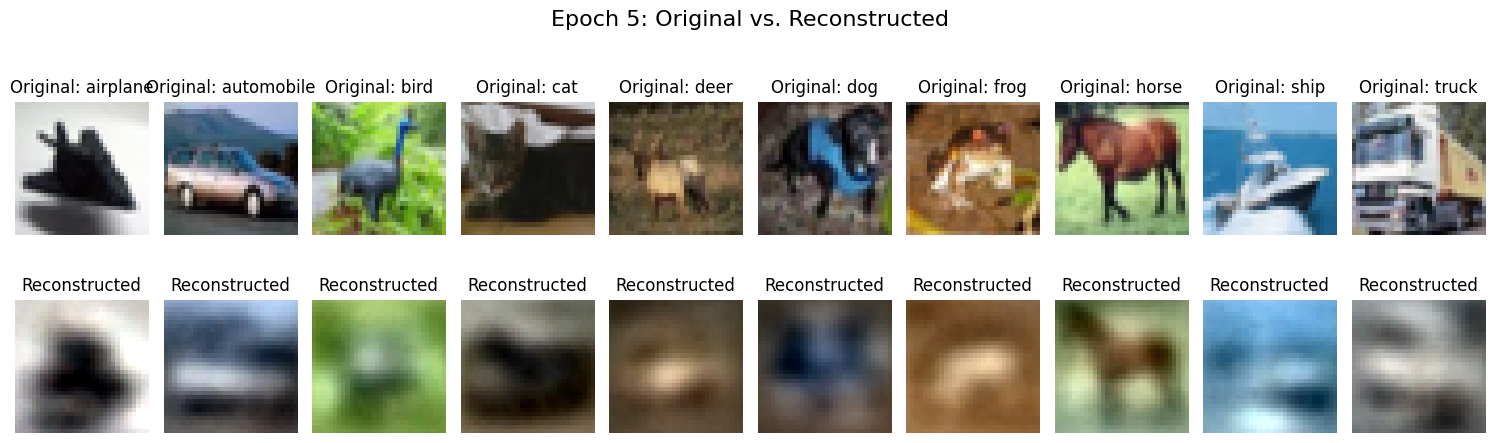

 17%|█▋        | 5/30 [08:47<45:26, 109.06s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


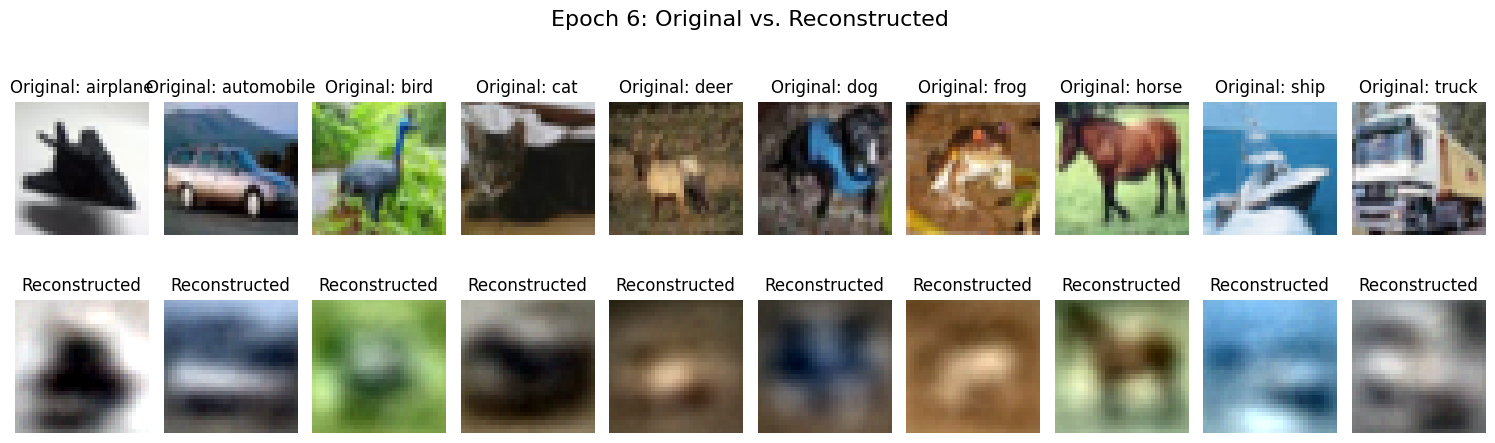

 20%|██        | 6/30 [10:37<43:45, 109.41s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


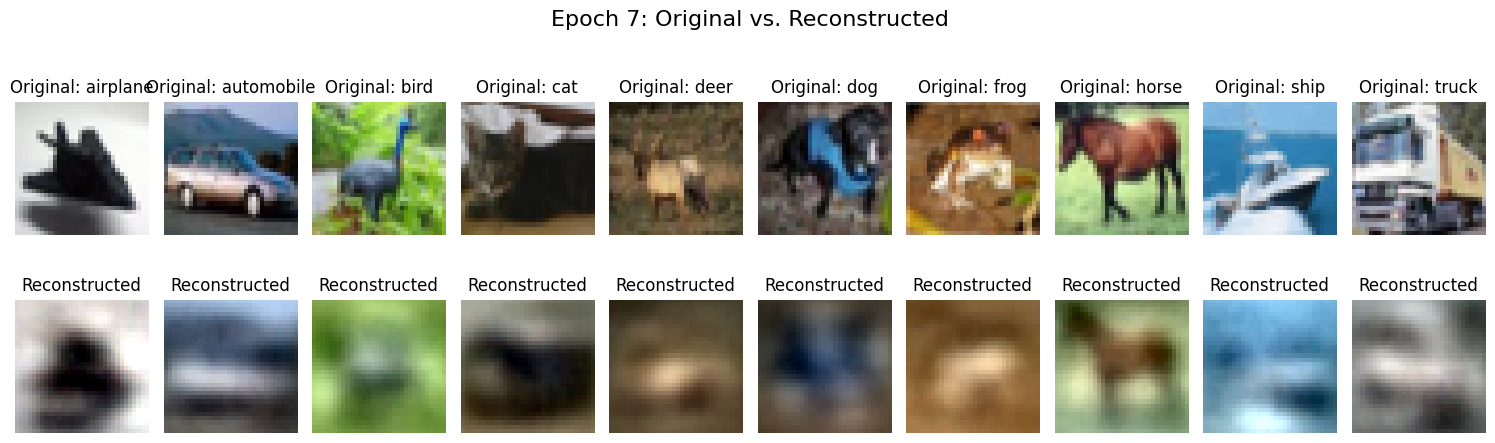

 23%|██▎       | 7/30 [13:05<43:01, 112.25s/it]


KeyboardInterrupt: 

In [ ]:
epochs = 30
for e in tqdm(range(epochs)):
    for X, label in train_loader:
        X = X.to(torch.float32)
        X_hat = auto_encoder(X)
        loss = criterion(X_hat, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    display_reconstructions(auto_encoder, train_dataset, e, device)

In [ ]:
torch.save(auto_encoder.state_dict(), 'cifar_auto_encoder_40.pt')